# Library

In [1]:
import random 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

# Seed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    
SEED = 42
set_seed(SEED)

# Data

In [3]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


# Model

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# Training

In [6]:
def train():
    epochs = 100
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        count = 0
        model.train()
        
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (y_pred.argmax(dim=1) == y_train).sum().item()
            count += len(y_train)
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc /= count
        train_accs.append(train_acc)
        
        val_loss = 0.0
        val_acc = 0.0
        count = 0
        model.eval()

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)
                val_loss += loss.item()
                val_acc += (y_pred.argmax(dim=1) == y_val).sum().item()
                count += len(y_val)
            
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc /= count
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
    return train_losses, val_losses, train_accs, val_accs

# Visualization

In [7]:
def visualize(train_losses, val_losses, train_accs, val_accs):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    ax[0, 0].plot(train_losses, color='green')
    ax[0, 0].set_title('Training Loss')
    ax[0, 0].set(xlabel='Epochs', ylabel='Loss')
    
    ax[0, 1].plot(val_losses, color='orange')
    ax[0, 1].set_title('Validation Loss')
    ax[0, 1].set(xlabel='Epochs', ylabel='Loss')
    
    ax[1, 0].plot(train_accs, color='green')
    ax[1, 0].set_title('Training Accuracy')
    ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy')
    
    ax[1, 1].plot(val_accs, color='orange')
    ax[1, 1].set_title('Validation Accuracy')
    ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy')

# Testing the model

In [8]:
def test():
    test_target = []
    test_predict = []

    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            
            test_predict.append(outputs.cpu())
            test_target.append(y_test.cpu())
            
        test_predict = torch.cat(test_predict, dim=0)
        test_target = torch.cat(test_target, dim=0)
        test_acc = (torch.argmax(test_predict, dim=1) == test_target).sum().item() / len(test_target)
        
        print(f"Accuracy on test set: {test_acc:.4f}")

# Training Implementation

## No optimized methods (Linear + Sigmoid)

In [9]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 2.3042, Train Acc: 0.0996, Val Loss: 2.3062, Val Acc: 0.0895
Epoch 2/100, Train Loss: 2.3040, Train Acc: 0.0989, Val Loss: 2.3025, Val Acc: 0.1003
Epoch 3/100, Train Loss: 2.3039, Train Acc: 0.0998, Val Loss: 2.3036, Val Acc: 0.0997
Epoch 4/100, Train Loss: 2.3038, Train Acc: 0.1010, Val Loss: 2.3042, Val Acc: 0.1012
Epoch 5/100, Train Loss: 2.3038, Train Acc: 0.0997, Val Loss: 2.3043, Val Acc: 0.1020
Epoch 6/100, Train Loss: 2.3039, Train Acc: 0.0990, Val Loss: 2.3024, Val Acc: 0.1022
Epoch 7/100, Train Loss: 2.3038, Train Acc: 0.0999, Val Loss: 2.3035, Val Acc: 0.1020
Epoch 8/100, Train Loss: 2.3038, Train Acc: 0.1015, Val Loss: 2.3040, Val Acc: 0.1022
Epoch 9/100, Train Loss: 2.3038, Train Acc: 0.1009, Val Loss: 2.3057, Val Acc: 0.1000
Epoch 10/100, Train Loss: 2.3039, Train Acc: 0.0996, Val Loss: 2.3038, Val Acc: 0.0937
Epoch 11/100, Train Loss: 2.3038, Train Acc: 0.0994, Val Loss: 2.3037, Val Acc: 0.1003
Epoch 12/100, Train Loss: 2.3040, Train Acc: 0.0973,

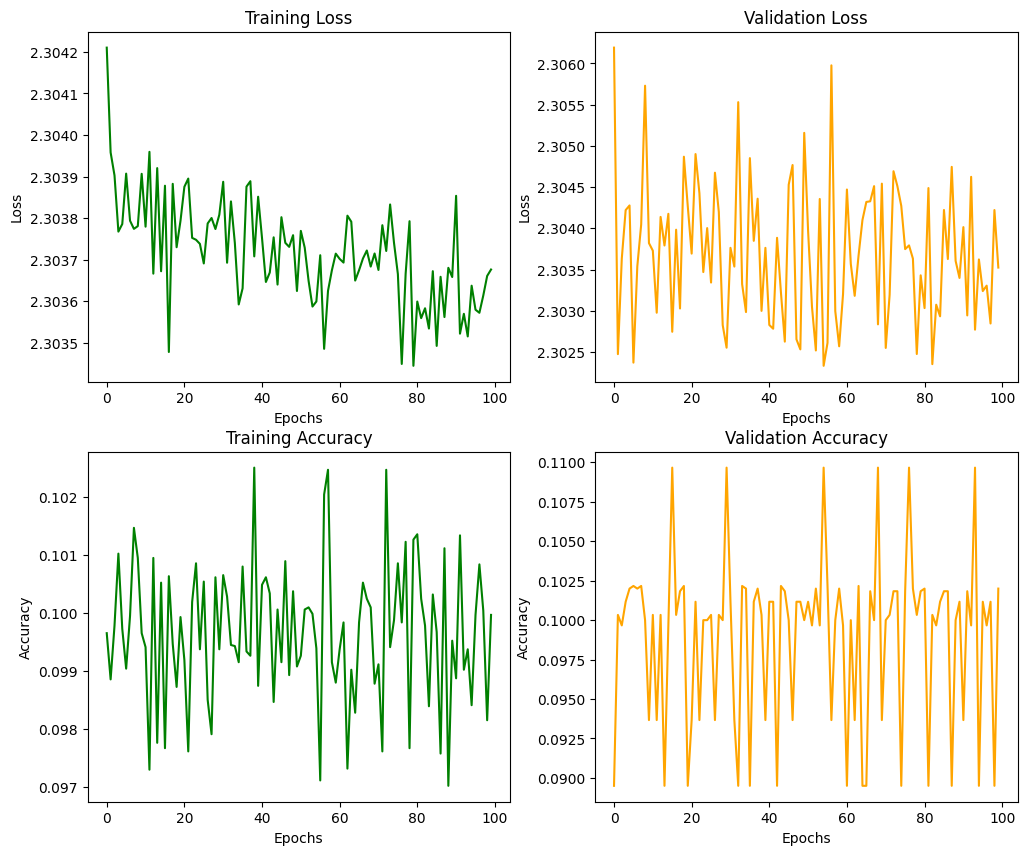

In [10]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [11]:
test()

Accuracy on test set: 0.1000


## Optimized 1: Increasing Weights

### STD = 1.0

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [13]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 1.7922, Train Acc: 0.4404, Val Loss: 1.2804, Val Acc: 0.5562
Epoch 2/100, Train Loss: 1.1533, Train Acc: 0.5882, Val Loss: 1.0928, Val Acc: 0.6095
Epoch 3/100, Train Loss: 1.0108, Train Acc: 0.6322, Val Loss: 1.0026, Val Acc: 0.6382
Epoch 4/100, Train Loss: 0.9332, Train Acc: 0.6598, Val Loss: 0.9476, Val Acc: 0.6582
Epoch 5/100, Train Loss: 0.8808, Train Acc: 0.6800, Val Loss: 0.9029, Val Acc: 0.6737
Epoch 6/100, Train Loss: 0.8423, Train Acc: 0.6941, Val Loss: 0.8646, Val Acc: 0.6900
Epoch 7/100, Train Loss: 0.8113, Train Acc: 0.7041, Val Loss: 0.8434, Val Acc: 0.7012
Epoch 8/100, Train Loss: 0.7859, Train Acc: 0.7139, Val Loss: 0.8159, Val Acc: 0.7102
Epoch 9/100, Train Loss: 0.7642, Train Acc: 0.7212, Val Loss: 0.8018, Val Acc: 0.7118
Epoch 10/100, Train Loss: 0.7459, Train Acc: 0.7277, Val Loss: 0.7820, Val Acc: 0.7193
Epoch 11/100, Train Loss: 0.7299, Train Acc: 0.7343, Val Loss: 0.7681, Val Acc: 0.7247
Epoch 12/100, Train Loss: 0.7159, Train Acc: 0.7389,

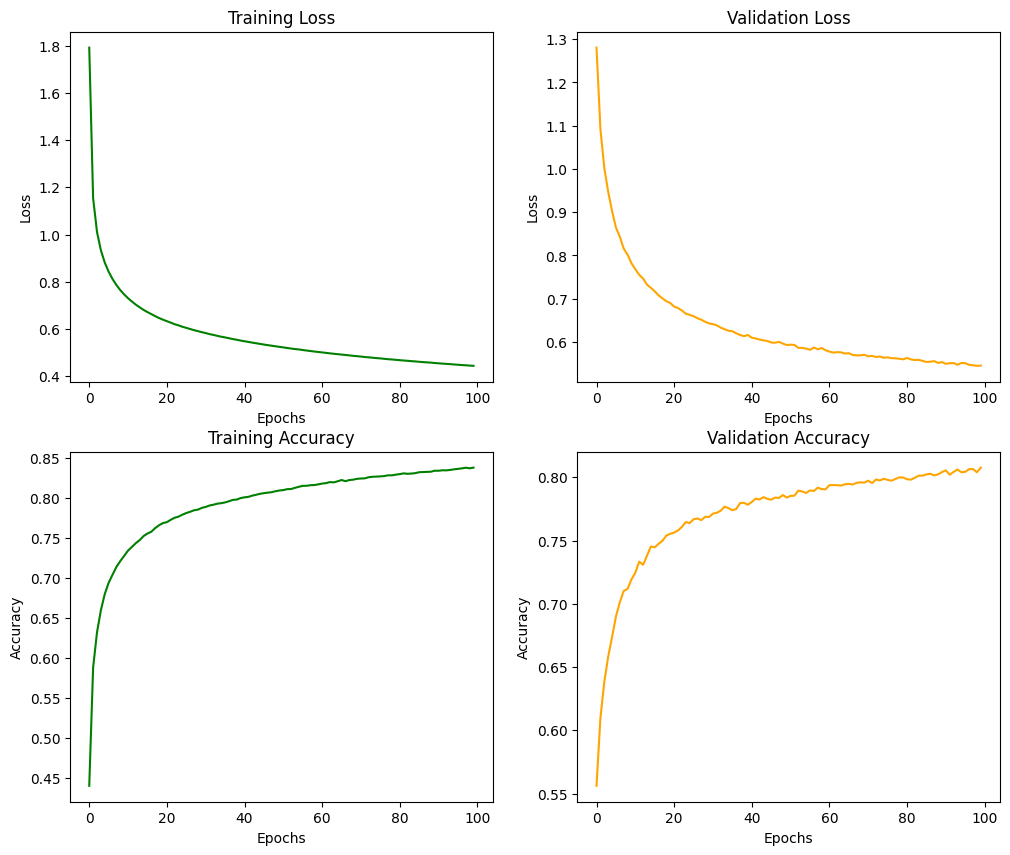

In [14]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [15]:
test()

Accuracy on test set: 0.8063


### STD = 10.0

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [17]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 48.2011, Train Acc: 0.1023, Val Loss: 17.4743, Val Acc: 0.1075
Epoch 2/100, Train Loss: 7.5883, Train Acc: 0.1006, Val Loss: 3.1394, Val Acc: 0.0947
Epoch 3/100, Train Loss: 2.9640, Train Acc: 0.1110, Val Loss: 2.6678, Val Acc: 0.1127
Epoch 4/100, Train Loss: 2.7382, Train Acc: 0.1028, Val Loss: 2.6762, Val Acc: 0.1067
Epoch 5/100, Train Loss: 2.6745, Train Acc: 0.1038, Val Loss: 2.5452, Val Acc: 0.1138
Epoch 6/100, Train Loss: 2.5933, Train Acc: 0.1076, Val Loss: 2.6061, Val Acc: 0.1058
Epoch 7/100, Train Loss: 2.6802, Train Acc: 0.1084, Val Loss: 2.5764, Val Acc: 0.1062
Epoch 8/100, Train Loss: 3.6345, Train Acc: 0.1075, Val Loss: 2.6346, Val Acc: 0.1028
Epoch 9/100, Train Loss: 2.5226, Train Acc: 0.1028, Val Loss: 2.4995, Val Acc: 0.1013
Epoch 10/100, Train Loss: 2.4026, Train Acc: 0.1026, Val Loss: 2.4311, Val Acc: 0.1047
Epoch 11/100, Train Loss: 2.3906, Train Acc: 0.1013, Val Loss: 2.4061, Val Acc: 0.1030
Epoch 12/100, Train Loss: 2.3684, Train Acc: 0.100

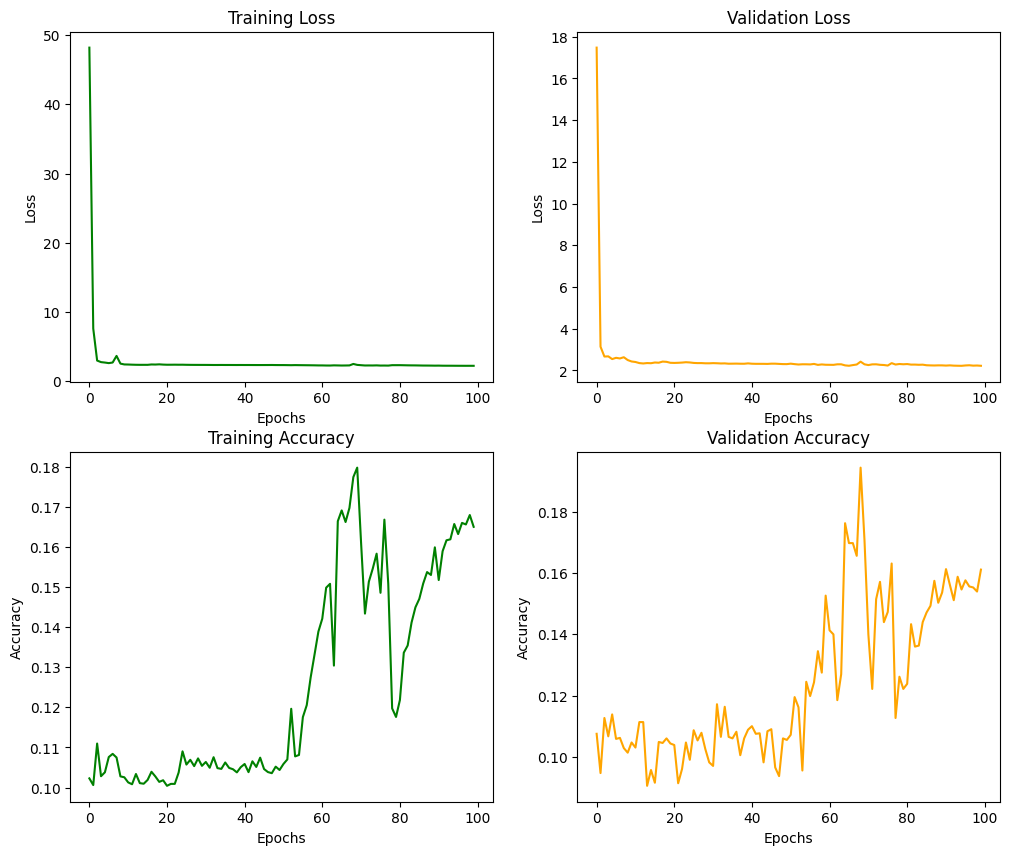

In [18]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [19]:
test()

Accuracy on test set: 0.1672


## Optimized 2: Changing Activation Function

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [21]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 2.3019, Train Acc: 0.1301, Val Loss: 2.3015, Val Acc: 0.0933
Epoch 2/100, Train Loss: 2.3005, Train Acc: 0.1219, Val Loss: 2.2995, Val Acc: 0.1708
Epoch 3/100, Train Loss: 2.2967, Train Acc: 0.2235, Val Loss: 2.2921, Val Acc: 0.2682
Epoch 4/100, Train Loss: 2.2489, Train Acc: 0.2504, Val Loss: 2.0783, Val Acc: 0.1947
Epoch 5/100, Train Loss: 1.6523, Train Acc: 0.3062, Val Loss: 1.1608, Val Acc: 0.5257
Epoch 6/100, Train Loss: 0.9851, Train Acc: 0.6080, Val Loss: 0.9780, Val Acc: 0.6167
Epoch 7/100, Train Loss: 0.8157, Train Acc: 0.6976, Val Loss: 0.7448, Val Acc: 0.7388
Epoch 8/100, Train Loss: 0.7155, Train Acc: 0.7386, Val Loss: 0.6730, Val Acc: 0.7582
Epoch 9/100, Train Loss: 0.6581, Train Acc: 0.7578, Val Loss: 0.6340, Val Acc: 0.7743
Epoch 10/100, Train Loss: 0.6064, Train Acc: 0.7764, Val Loss: 0.6079, Val Acc: 0.7785
Epoch 11/100, Train Loss: 0.5672, Train Acc: 0.7902, Val Loss: 0.6627, Val Acc: 0.7660
Epoch 12/100, Train Loss: 0.5389, Train Acc: 0.7997,

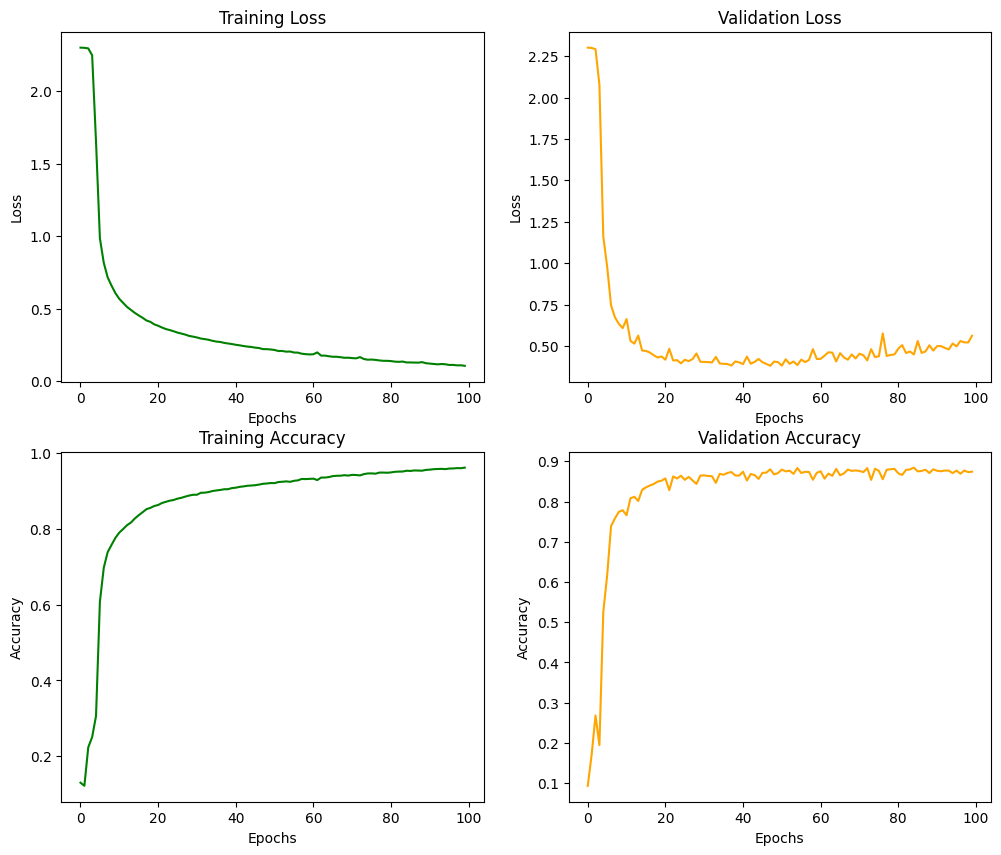

In [22]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [23]:
test()

Accuracy on test set: 0.8785


## Optimized 3: Changing Optimizer

In [24]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 2.3052, Train Acc: 0.0982, Val Loss: 2.3047, Val Acc: 0.1000
Epoch 2/100, Train Loss: 2.3033, Train Acc: 0.1012, Val Loss: 2.3046, Val Acc: 0.0937
Epoch 3/100, Train Loss: 2.3036, Train Acc: 0.1015, Val Loss: 2.3029, Val Acc: 0.1012
Epoch 4/100, Train Loss: 2.2249, Train Acc: 0.1191, Val Loss: 1.8687, Val Acc: 0.1973
Epoch 5/100, Train Loss: 1.6401, Train Acc: 0.2674, Val Loss: 1.4539, Val Acc: 0.3413
Epoch 6/100, Train Loss: 1.6141, Train Acc: 0.3020, Val Loss: 1.6601, Val Acc: 0.2798
Epoch 7/100, Train Loss: 1.5051, Train Acc: 0.3459, Val Loss: 1.4305, Val Acc: 0.3605
Epoch 8/100, Train Loss: 1.4062, Train Acc: 0.3849, Val Loss: 1.3946, Val Acc: 0.4032
Epoch 9/100, Train Loss: 1.4515, Train Acc: 0.3806, Val Loss: 1.3911, Val Acc: 0.4543
Epoch 10/100, Train Loss: 1.3254, Train Acc: 0.4231, Val Loss: 1.1933, Val Acc: 0.4555
Epoch 11/100, Train Loss: 1.1659, Train Acc: 0.5057, Val Loss: 1.5869, Val Acc: 0.3645
Epoch 12/100, Train Loss: 1.2125, Train Acc: 0.5048,

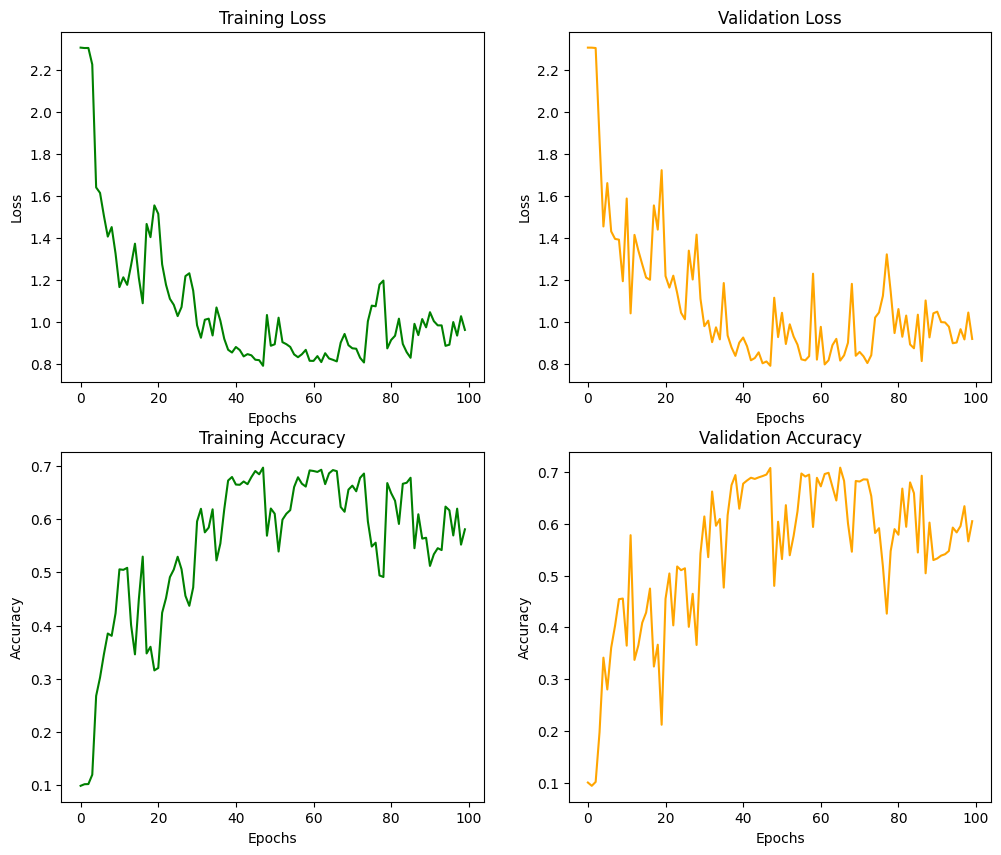

In [26]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [27]:
test()

Accuracy on test set: 0.6002


## Optimized 4: Batch Normalization

### Normalized Inside Network

In [30]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        self.hidden_dims = hidden_dims
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [31]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 1.2288, Train Acc: 0.7226, Val Loss: 0.8345, Val Acc: 0.7927
Epoch 2/100, Train Loss: 0.6973, Train Acc: 0.8128, Val Loss: 0.6222, Val Acc: 0.8193
Epoch 3/100, Train Loss: 0.5587, Train Acc: 0.8339, Val Loss: 0.5389, Val Acc: 0.8312
Epoch 4/100, Train Loss: 0.4961, Train Acc: 0.8438, Val Loss: 0.4990, Val Acc: 0.8388
Epoch 5/100, Train Loss: 0.4564, Train Acc: 0.8529, Val Loss: 0.4724, Val Acc: 0.8435
Epoch 6/100, Train Loss: 0.4313, Train Acc: 0.8575, Val Loss: 0.4470, Val Acc: 0.8490
Epoch 7/100, Train Loss: 0.4095, Train Acc: 0.8644, Val Loss: 0.4243, Val Acc: 0.8545
Epoch 8/100, Train Loss: 0.3935, Train Acc: 0.8679, Val Loss: 0.4249, Val Acc: 0.8527
Epoch 9/100, Train Loss: 0.3780, Train Acc: 0.8713, Val Loss: 0.3979, Val Acc: 0.8625
Epoch 10/100, Train Loss: 0.3667, Train Acc: 0.8754, Val Loss: 0.3984, Val Acc: 0.8612
Epoch 11/100, Train Loss: 0.3571, Train Acc: 0.8774, Val Loss: 0.3994, Val Acc: 0.8603
Epoch 12/100, Train Loss: 0.3479, Train Acc: 0.8805,

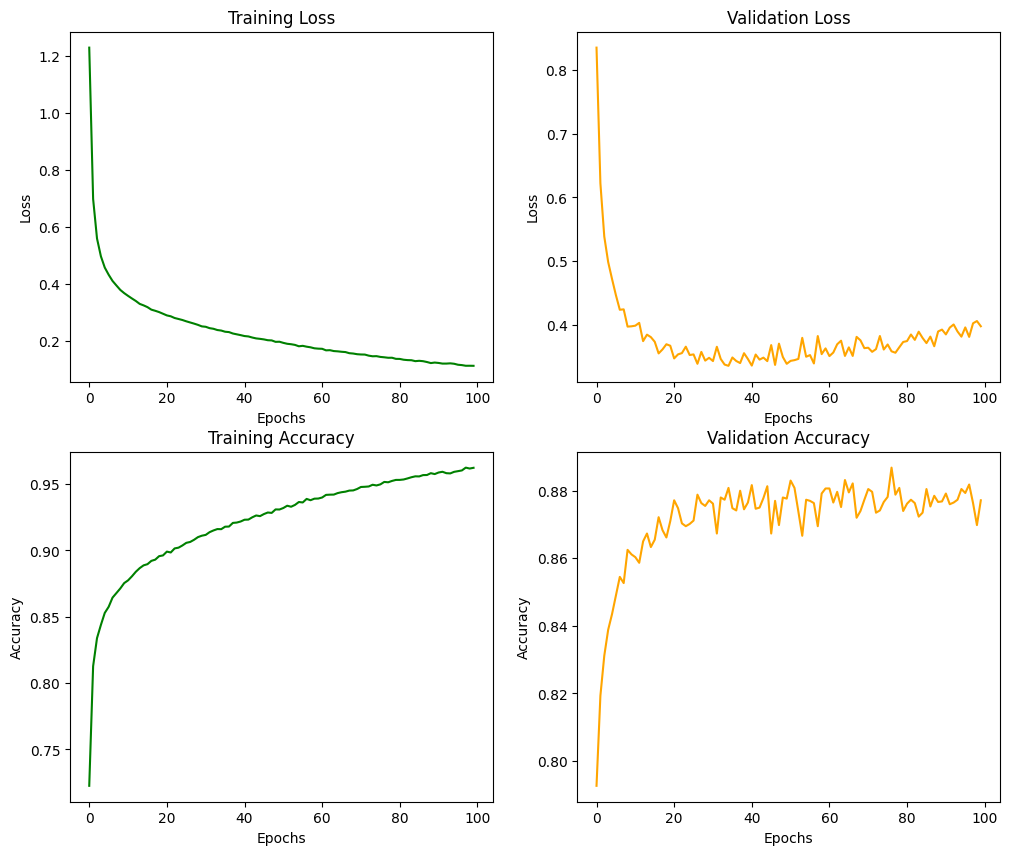

In [32]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [33]:
test()

Accuracy on test set: 0.8736


### Customized Normalization Layer

In [34]:
class MyNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

In [35]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [36]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 2.3048, Train Acc: 0.1009, Val Loss: 2.3050, Val Acc: 0.0997
Epoch 2/100, Train Loss: 2.3042, Train Acc: 0.0985, Val Loss: 2.3025, Val Acc: 0.1022
Epoch 3/100, Train Loss: 2.3041, Train Acc: 0.0987, Val Loss: 2.3042, Val Acc: 0.1020
Epoch 4/100, Train Loss: 2.3039, Train Acc: 0.1004, Val Loss: 2.3048, Val Acc: 0.1215
Epoch 5/100, Train Loss: 2.3039, Train Acc: 0.1017, Val Loss: 2.3034, Val Acc: 0.0895
Epoch 6/100, Train Loss: 2.3035, Train Acc: 0.1013, Val Loss: 2.3051, Val Acc: 0.1495
Epoch 7/100, Train Loss: 2.3026, Train Acc: 0.1062, Val Loss: 2.3036, Val Acc: 0.1018
Epoch 8/100, Train Loss: 2.2348, Train Acc: 0.1832, Val Loss: 1.6859, Val Acc: 0.6087
Epoch 9/100, Train Loss: 1.1482, Train Acc: 0.6952, Val Loss: 0.8626, Val Acc: 0.7457
Epoch 10/100, Train Loss: 0.7418, Train Acc: 0.7739, Val Loss: 0.6639, Val Acc: 0.7938
Epoch 11/100, Train Loss: 0.6102, Train Acc: 0.8071, Val Loss: 0.5828, Val Acc: 0.8150
Epoch 12/100, Train Loss: 0.5523, Train Acc: 0.8190,

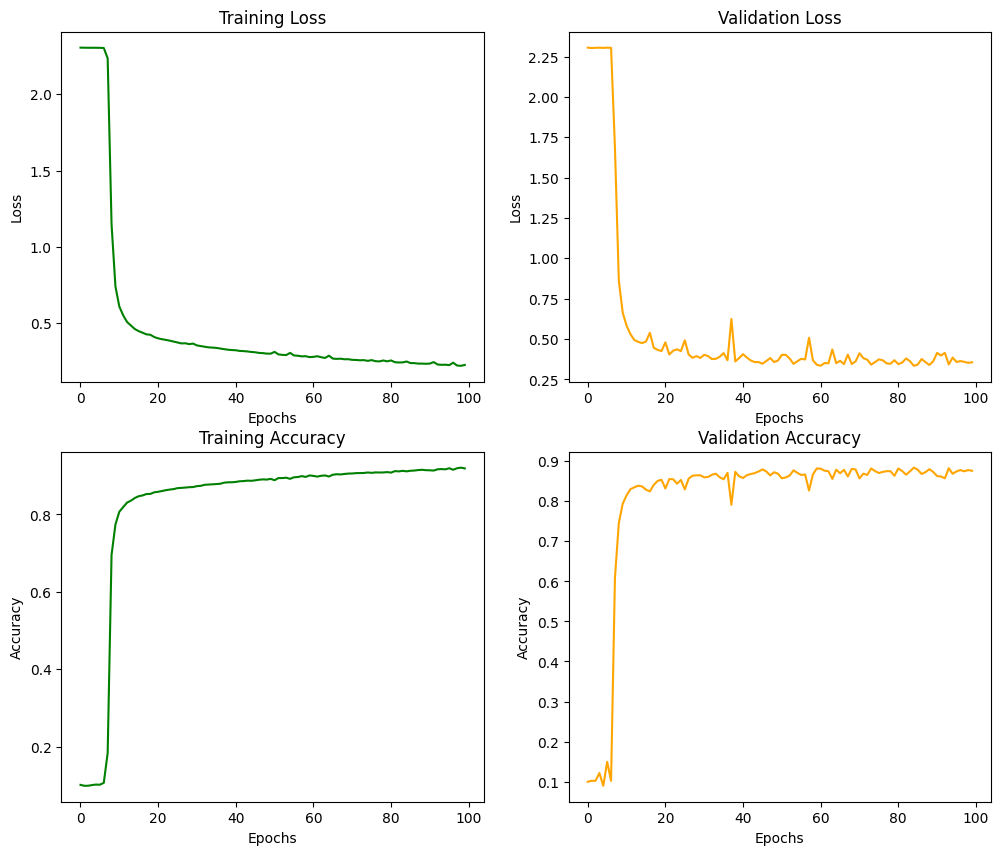

In [37]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [38]:
test()

Accuracy on test set: 0.8693


## Optimized 5: Skip-connection

In [39]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x
        
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x
        
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)   

In [40]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 2.2986, Train Acc: 0.1176, Val Loss: 2.2875, Val Acc: 0.1018
Epoch 2/100, Train Loss: 2.2673, Train Acc: 0.1765, Val Loss: 2.2399, Val Acc: 0.1130
Epoch 3/100, Train Loss: 2.1720, Train Acc: 0.2856, Val Loss: 2.0741, Val Acc: 0.2317
Epoch 4/100, Train Loss: 1.9009, Train Acc: 0.3835, Val Loss: 1.7410, Val Acc: 0.4375
Epoch 5/100, Train Loss: 1.6116, Train Acc: 0.4622, Val Loss: 1.5181, Val Acc: 0.4030
Epoch 6/100, Train Loss: 1.4094, Train Acc: 0.5287, Val Loss: 1.3378, Val Acc: 0.5463
Epoch 7/100, Train Loss: 1.2633, Train Acc: 0.5682, Val Loss: 1.2205, Val Acc: 0.5795
Epoch 8/100, Train Loss: 1.1619, Train Acc: 0.5934, Val Loss: 1.1418, Val Acc: 0.5585
Epoch 9/100, Train Loss: 1.0885, Train Acc: 0.6095, Val Loss: 1.0723, Val Acc: 0.6003
Epoch 10/100, Train Loss: 1.0313, Train Acc: 0.6233, Val Loss: 1.0234, Val Acc: 0.6202
Epoch 11/100, Train Loss: 0.9839, Train Acc: 0.6359, Val Loss: 0.9797, Val Acc: 0.6208
Epoch 12/100, Train Loss: 0.9428, Train Acc: 0.6501,

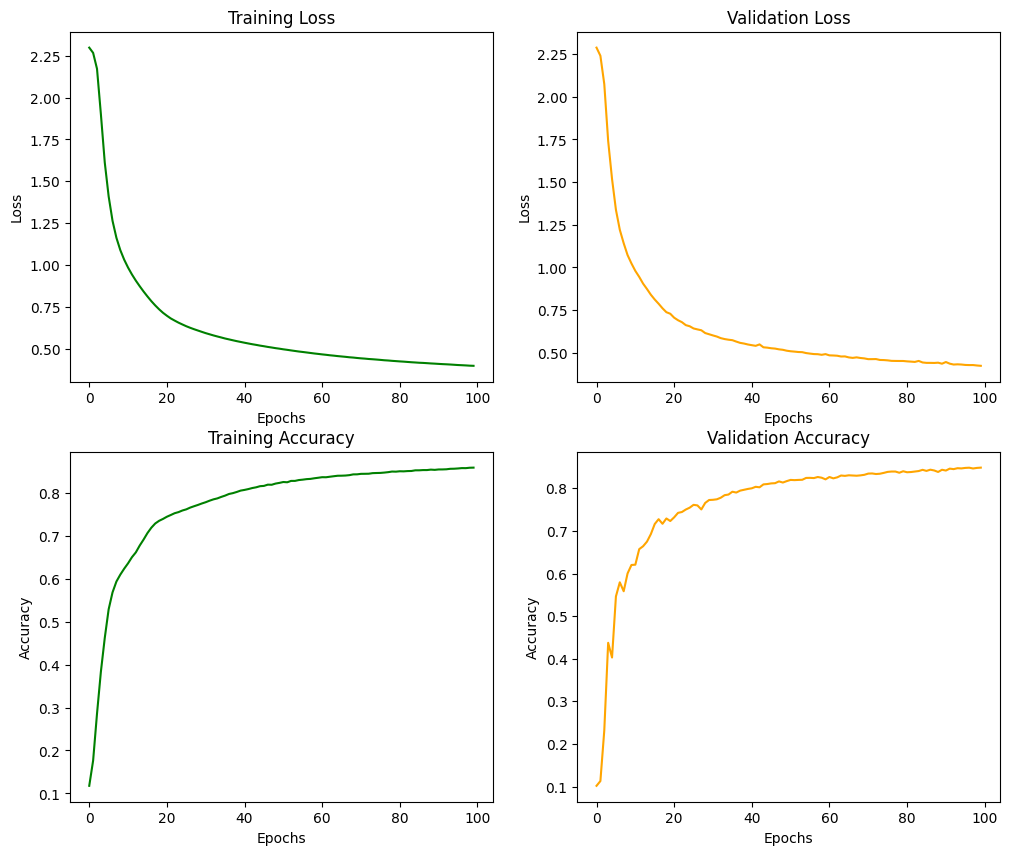

In [41]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [42]:
test()

Accuracy on test set: 0.8424


## Optimized 6: Fine-tunning

### a) Model Components

In [43]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)        
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
                
    def forward(self, x):  
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        
        return x
    
class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        
        return x

### b) Sub-Model Components

In [46]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

### c) Training the first component

In [47]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train() 

Epoch 1/100, Train Loss: 2.2910, Train Acc: 0.1612, Val Loss: 2.2755, Val Acc: 0.1675
Epoch 2/100, Train Loss: 2.2466, Train Acc: 0.2887, Val Loss: 2.2057, Val Acc: 0.4542
Epoch 3/100, Train Loss: 2.1040, Train Acc: 0.3901, Val Loss: 1.9657, Val Acc: 0.4005
Epoch 4/100, Train Loss: 1.8035, Train Acc: 0.4666, Val Loss: 1.6743, Val Acc: 0.5402
Epoch 5/100, Train Loss: 1.5580, Train Acc: 0.5191, Val Loss: 1.4655, Val Acc: 0.5692
Epoch 6/100, Train Loss: 1.3696, Train Acc: 0.5648, Val Loss: 1.3026, Val Acc: 0.5650
Epoch 7/100, Train Loss: 1.2313, Train Acc: 0.5882, Val Loss: 1.1894, Val Acc: 0.5813
Epoch 8/100, Train Loss: 1.1344, Train Acc: 0.6044, Val Loss: 1.1109, Val Acc: 0.5957
Epoch 9/100, Train Loss: 1.0633, Train Acc: 0.6190, Val Loss: 1.0482, Val Acc: 0.6233
Epoch 10/100, Train Loss: 1.0080, Train Acc: 0.6340, Val Loss: 0.9997, Val Acc: 0.6292
Epoch 11/100, Train Loss: 0.9618, Train Acc: 0.6461, Val Loss: 0.9572, Val Acc: 0.6520
Epoch 12/100, Train Loss: 0.9210, Train Acc: 0.6646,

([2.290958548891601,
  2.246600054734126,
  2.103979153231987,
  1.8035251758109903,
  1.5579726087256065,
  1.3695847242364387,
  1.231310868715223,
  1.1344265581872226,
  1.063306136224507,
  1.0079585818741559,
  0.9618153303014159,
  0.9210178322419171,
  0.884084162130175,
  0.8507950637860321,
  0.8204643413495113,
  0.7935124069311043,
  0.7691488058010548,
  0.7473254300194894,
  0.7275186756281491,
  0.7099882080727279,
  0.6944196801544366,
  0.6801114514540721,
  0.6673809953775451,
  0.6556116963308569,
  0.6450586853928476,
  0.6350597774177366,
  0.6256679063089086,
  0.6168877695691529,
  0.6084596875931414,
  0.6010408385599394,
  0.5938507404655077,
  0.5868521173842145,
  0.580263818256663,
  0.5742034917052888,
  0.5683346612122951,
  0.5627541944243332,
  0.5575386292844022,
  0.552457676891467,
  0.5476685521585681,
  0.5430555346805902,
  0.5384608180884501,
  0.5340790417557362,
  0.5300087244095395,
  0.5259416642559083,
  0.5220801662918516,
  0.51824836116902

### d) Adding the second component

In [48]:
for param in model.parameters():
    param.requires_grad = False
    
model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train()

Epoch 1/100, Train Loss: 2.3018, Train Acc: 0.1079, Val Loss: 2.2974, Val Acc: 0.1860
Epoch 2/100, Train Loss: 2.2956, Train Acc: 0.1342, Val Loss: 2.2911, Val Acc: 0.0997
Epoch 3/100, Train Loss: 2.2866, Train Acc: 0.1705, Val Loss: 2.2799, Val Acc: 0.2708
Epoch 4/100, Train Loss: 2.2689, Train Acc: 0.2216, Val Loss: 2.2543, Val Acc: 0.2683
Epoch 5/100, Train Loss: 2.2237, Train Acc: 0.2816, Val Loss: 2.1814, Val Acc: 0.4567
Epoch 6/100, Train Loss: 2.0944, Train Acc: 0.3160, Val Loss: 1.9891, Val Acc: 0.3208
Epoch 7/100, Train Loss: 1.8588, Train Acc: 0.3927, Val Loss: 1.7544, Val Acc: 0.4018
Epoch 8/100, Train Loss: 1.6772, Train Acc: 0.4926, Val Loss: 1.6211, Val Acc: 0.5795
Epoch 9/100, Train Loss: 1.5650, Train Acc: 0.5340, Val Loss: 1.5224, Val Acc: 0.5172
Epoch 10/100, Train Loss: 1.4642, Train Acc: 0.5652, Val Loss: 1.4165, Val Acc: 0.6263
Epoch 11/100, Train Loss: 1.3498, Train Acc: 0.6049, Val Loss: 1.2980, Val Acc: 0.6147
Epoch 12/100, Train Loss: 1.2322, Train Acc: 0.6556,

([2.3018352940184243,
  2.2955549873446968,
  2.286648999740727,
  2.2689076919126285,
  2.2237330954786727,
  2.0943855466718357,
  1.8587907472210472,
  1.6772239920087335,
  1.5650479816147502,
  1.4641543725655541,
  1.3498444497867783,
  1.232173626739267,
  1.1332719126160111,
  1.0527730356742986,
  0.9843985565465774,
  0.9248159620292944,
  0.8740860408798778,
  0.8317036114597772,
  0.7972528808772281,
  0.7689393020777906,
  0.7451659565288309,
  0.7244421691408655,
  0.705830837842695,
  0.6885258957602401,
  0.6718722686030288,
  0.6552398074859691,
  0.6389028952231904,
  0.6220319002019286,
  0.6053561007877661,
  0.5887437568739127,
  0.5729097622971964,
  0.5579790574326334,
  0.544500408579388,
  0.5323721230983451,
  0.5219532684268544,
  0.5129045370207014,
  0.5046457368615679,
  0.49779149353221697,
  0.49165020093886774,
  0.486020549443237,
  0.4810005259033628,
  0.4768518684564326,
  0.4727800222581597,
  0.4690577474674342,
  0.4657590228410976,
  0.462678373

### e) Update all the existed components

In [49]:
for param in model.parameters():
    param.requires_grad = True 
    
model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train()

Epoch 1/100, Train Loss: 1.3062, Train Acc: 0.7422, Val Loss: 0.8769, Val Acc: 0.8158
Epoch 2/100, Train Loss: 0.7253, Train Acc: 0.8292, Val Loss: 0.6473, Val Acc: 0.8258
Epoch 3/100, Train Loss: 0.5833, Train Acc: 0.8355, Val Loss: 0.5642, Val Acc: 0.8298
Epoch 4/100, Train Loss: 0.5236, Train Acc: 0.8402, Val Loss: 0.5238, Val Acc: 0.8325
Epoch 5/100, Train Loss: 0.4917, Train Acc: 0.8421, Val Loss: 0.5001, Val Acc: 0.8375
Epoch 6/100, Train Loss: 0.4722, Train Acc: 0.8454, Val Loss: 0.4846, Val Acc: 0.8385
Epoch 7/100, Train Loss: 0.4588, Train Acc: 0.8470, Val Loss: 0.4749, Val Acc: 0.8385
Epoch 8/100, Train Loss: 0.4490, Train Acc: 0.8488, Val Loss: 0.4662, Val Acc: 0.8403
Epoch 9/100, Train Loss: 0.4417, Train Acc: 0.8505, Val Loss: 0.4635, Val Acc: 0.8403
Epoch 10/100, Train Loss: 0.4359, Train Acc: 0.8511, Val Loss: 0.4568, Val Acc: 0.8418
Epoch 11/100, Train Loss: 0.4309, Train Acc: 0.8519, Val Loss: 0.4535, Val Acc: 0.8435
Epoch 12/100, Train Loss: 0.4267, Train Acc: 0.8525,

([1.3061953983600672,
  0.7253445297550251,
  0.5833319171698172,
  0.5235670438098117,
  0.4916608769676132,
  0.47216423696251275,
  0.4588160198270145,
  0.44897033381871704,
  0.4416844027549452,
  0.4358970978389984,
  0.43087135024050965,
  0.4266848854755903,
  0.4230185667344179,
  0.4197979508700529,
  0.4168016783434068,
  0.4140852978938564,
  0.4114597924406777,
  0.40938131345250595,
  0.40705702376167924,
  0.40480830096661763,
  0.40256937513772345,
  0.4009302126958754,
  0.39889143301412394,
  0.3972428015199318,
  0.39518772861898227,
  0.3936252801445141,
  0.3919372313889847,
  0.39032503519366135,
  0.388584922363549,
  0.3870602518284773,
  0.3856101914251585,
  0.3840487986114494,
  0.3825373317499014,
  0.381407305448188,
  0.3797290216584059,
  0.37855131481001725,
  0.37736829304935243,
  0.37558536448679264,
  0.37441392776101684,
  0.3730200951768889,
  0.3718102185576448,
  0.3705360878665018,
  0.36936680032425867,
  0.3679021135925964,
  0.366805963818495

### f) Adding the third component

In [50]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
    
model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train()

Epoch 1/100, Train Loss: 2.3013, Train Acc: 0.1130, Val Loss: 2.2961, Val Acc: 0.1055
Epoch 2/100, Train Loss: 2.2916, Train Acc: 0.1378, Val Loss: 2.2856, Val Acc: 0.0940
Epoch 3/100, Train Loss: 2.2752, Train Acc: 0.2027, Val Loss: 2.2607, Val Acc: 0.1003
Epoch 4/100, Train Loss: 2.2321, Train Acc: 0.2724, Val Loss: 2.1913, Val Acc: 0.3153
Epoch 5/100, Train Loss: 2.0933, Train Acc: 0.3321, Val Loss: 1.9685, Val Acc: 0.4392
Epoch 6/100, Train Loss: 1.8246, Train Acc: 0.4241, Val Loss: 1.7118, Val Acc: 0.3935
Epoch 7/100, Train Loss: 1.6263, Train Acc: 0.5594, Val Loss: 1.5644, Val Acc: 0.5780
Epoch 8/100, Train Loss: 1.4899, Train Acc: 0.6100, Val Loss: 1.4290, Val Acc: 0.6090
Epoch 9/100, Train Loss: 1.3412, Train Acc: 0.6689, Val Loss: 1.2690, Val Acc: 0.6868
Epoch 10/100, Train Loss: 1.1772, Train Acc: 0.7233, Val Loss: 1.1139, Val Acc: 0.7232
Epoch 11/100, Train Loss: 1.0359, Train Acc: 0.7602, Val Loss: 0.9909, Val Acc: 0.7640
Epoch 12/100, Train Loss: 0.9204, Train Acc: 0.7779,

([2.3013058977104475,
  2.291648164179653,
  2.275163337800175,
  2.232064912951953,
  2.0933453516937544,
  1.8246022205782162,
  1.6263132524716346,
  1.4899481159250882,
  1.3411639909043696,
  1.177161166170762,
  1.0358525989886145,
  0.9204122807601052,
  0.8258752099710618,
  0.7516068155166662,
  0.6942522405377497,
  0.6488199966708066,
  0.6107733670569144,
  0.5770788746775609,
  0.5462714677314623,
  0.5174564778169185,
  0.4902876840630696,
  0.46488495513584943,
  0.44168477032280645,
  0.4210553369462773,
  0.40373121938222395,
  0.38920636981796314,
  0.3777445731110765,
  0.36828774150231436,
  0.3607985172155909,
  0.354863563014009,
  0.34994223661791374,
  0.3459193012831618,
  0.3425863508082114,
  0.3396858265402758,
  0.3373401168186518,
  0.3352699463754469,
  0.33355955590639635,
  0.33202529048891427,
  0.33062060981529867,
  0.3293856853857566,
  0.32857809849613084,
  0.32742170266524595,
  0.3266878552311122,
  0.32588516426453656,
  0.3253027240070404,
  0

### g) Update all the existed components

In [51]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
    
model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train()

Epoch 1/100, Train Loss: 1.1763, Train Acc: 0.8180, Val Loss: 0.7264, Val Acc: 0.8602
Epoch 2/100, Train Loss: 0.5739, Train Acc: 0.8749, Val Loss: 0.5125, Val Acc: 0.8653
Epoch 3/100, Train Loss: 0.4469, Train Acc: 0.8794, Val Loss: 0.4475, Val Acc: 0.8680
Epoch 4/100, Train Loss: 0.3984, Train Acc: 0.8812, Val Loss: 0.4175, Val Acc: 0.8707
Epoch 5/100, Train Loss: 0.3741, Train Acc: 0.8831, Val Loss: 0.4032, Val Acc: 0.8712
Epoch 6/100, Train Loss: 0.3603, Train Acc: 0.8838, Val Loss: 0.3940, Val Acc: 0.8727
Epoch 7/100, Train Loss: 0.3509, Train Acc: 0.8850, Val Loss: 0.3886, Val Acc: 0.8732
Epoch 8/100, Train Loss: 0.3441, Train Acc: 0.8857, Val Loss: 0.3845, Val Acc: 0.8737
Epoch 9/100, Train Loss: 0.3394, Train Acc: 0.8865, Val Loss: 0.3802, Val Acc: 0.8728
Epoch 10/100, Train Loss: 0.3348, Train Acc: 0.8874, Val Loss: 0.3812, Val Acc: 0.8753
Epoch 11/100, Train Loss: 0.3317, Train Acc: 0.8881, Val Loss: 0.3805, Val Acc: 0.8705
Epoch 12/100, Train Loss: 0.3293, Train Acc: 0.8881,

([1.1762764193294173,
  0.573883056464071,
  0.44689776028078315,
  0.3984168666587057,
  0.37406850002388253,
  0.3602697931547865,
  0.350897556709311,
  0.34407823350969086,
  0.3393967617038302,
  0.3348452794361171,
  0.3316770500958107,
  0.3292770718370004,
  0.326500471575424,
  0.3239672065346162,
  0.32232609035456067,
  0.3206235792982211,
  0.31893438780547884,
  0.31701484896348553,
  0.31591762780648835,
  0.31438231885750995,
  0.3131798172007664,
  0.3117640943518041,
  0.310460595458181,
  0.3097787983627257,
  0.30869513469355364,
  0.30725003055062905,
  0.3060971036182619,
  0.3053038215697235,
  0.30391069496341794,
  0.3029433914782453,
  0.3024242215953167,
  0.3010208300840092,
  0.30013751317151066,
  0.2991522327065468,
  0.29862087926169706,
  0.2973153318644841,
  0.2970129846732057,
  0.2961000702586643,
  0.2946345987531105,
  0.29432368756082106,
  0.2931338277208438,
  0.2923194388748628,
  0.2919164400247601,
  0.29075148736978595,
  0.2897402442709247,

### h) Adding the fourth component

In [52]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False
    
model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train()

Epoch 1/100, Train Loss: 2.0854, Train Acc: 0.5600, Val Loss: 1.8050, Val Acc: 0.8413
Epoch 2/100, Train Loss: 1.4610, Train Acc: 0.8619, Val Loss: 1.1752, Val Acc: 0.8685
Epoch 3/100, Train Loss: 0.9365, Train Acc: 0.9011, Val Loss: 0.7897, Val Acc: 0.8727
Epoch 4/100, Train Loss: 0.6418, Train Acc: 0.9094, Val Loss: 0.5899, Val Acc: 0.8773
Epoch 5/100, Train Loss: 0.4866, Train Acc: 0.9119, Val Loss: 0.4883, Val Acc: 0.8775
Epoch 6/100, Train Loss: 0.4031, Train Acc: 0.9132, Val Loss: 0.4335, Val Acc: 0.8783
Epoch 7/100, Train Loss: 0.3554, Train Acc: 0.9139, Val Loss: 0.4033, Val Acc: 0.8780
Epoch 8/100, Train Loss: 0.3264, Train Acc: 0.9141, Val Loss: 0.3848, Val Acc: 0.8800
Epoch 9/100, Train Loss: 0.3078, Train Acc: 0.9141, Val Loss: 0.3749, Val Acc: 0.8793
Epoch 10/100, Train Loss: 0.2949, Train Acc: 0.9138, Val Loss: 0.3670, Val Acc: 0.8797
Epoch 11/100, Train Loss: 0.2859, Train Acc: 0.9143, Val Loss: 0.3623, Val Acc: 0.8803
Epoch 12/100, Train Loss: 0.2791, Train Acc: 0.9144,

([2.085367633691896,
  1.4609719119365747,
  0.9365108590837904,
  0.6418072493720394,
  0.4865633282121889,
  0.40305386047580793,
  0.3554416731953338,
  0.32644625426539314,
  0.30780917988710493,
  0.29490981641185793,
  0.2858612545064134,
  0.27906873237818336,
  0.27411268532311467,
  0.26996380888737775,
  0.2668222226025934,
  0.26421696893093993,
  0.2620282115423566,
  0.2602380387467372,
  0.2587740966758881,
  0.25754020198014393,
  0.2563580613653948,
  0.25548687456749486,
  0.2546210952579834,
  0.25398459534438866,
  0.2533086963545231,
  0.25262950622074976,
  0.25225343948927537,
  0.2516959800045072,
  0.2512924401266103,
  0.2508191772917577,
  0.250515322584959,
  0.2502559289265583,
  0.24997521439893833,
  0.24964400077176885,
  0.2492594667026217,
  0.24915308095691327,
  0.24894696222485807,
  0.2487085747369234,
  0.2485786015388525,
  0.24832857729452198,
  0.24820578373280042,
  0.24802532900672106,
  0.24783975412512985,
  0.2477387905880032,
  0.247485988

### f) Unlock all components

In [53]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 1.0516, Train Acc: 0.8474, Val Loss: 0.6066, Val Acc: 0.8730
Epoch 2/100, Train Loss: 0.4566, Train Acc: 0.9036, Val Loss: 0.4399, Val Acc: 0.8782
Epoch 3/100, Train Loss: 0.3546, Train Acc: 0.9065, Val Loss: 0.3959, Val Acc: 0.8787
Epoch 4/100, Train Loss: 0.3164, Train Acc: 0.9079, Val Loss: 0.3722, Val Acc: 0.8803
Epoch 5/100, Train Loss: 0.2977, Train Acc: 0.9101, Val Loss: 0.3645, Val Acc: 0.8820
Epoch 6/100, Train Loss: 0.2861, Train Acc: 0.9104, Val Loss: 0.3588, Val Acc: 0.8797
Epoch 7/100, Train Loss: 0.2790, Train Acc: 0.9112, Val Loss: 0.3639, Val Acc: 0.8808
Epoch 8/100, Train Loss: 0.2736, Train Acc: 0.9115, Val Loss: 0.3620, Val Acc: 0.8812
Epoch 9/100, Train Loss: 0.2697, Train Acc: 0.9112, Val Loss: 0.3544, Val Acc: 0.8802
Epoch 10/100, Train Loss: 0.2670, Train Acc: 0.9114, Val Loss: 0.3656, Val Acc: 0.8773
Epoch 11/100, Train Loss: 0.2637, Train Acc: 0.9125, Val Loss: 0.3639, Val Acc: 0.8757
Epoch 12/100, Train Loss: 0.2626, Train Acc: 0.9122,

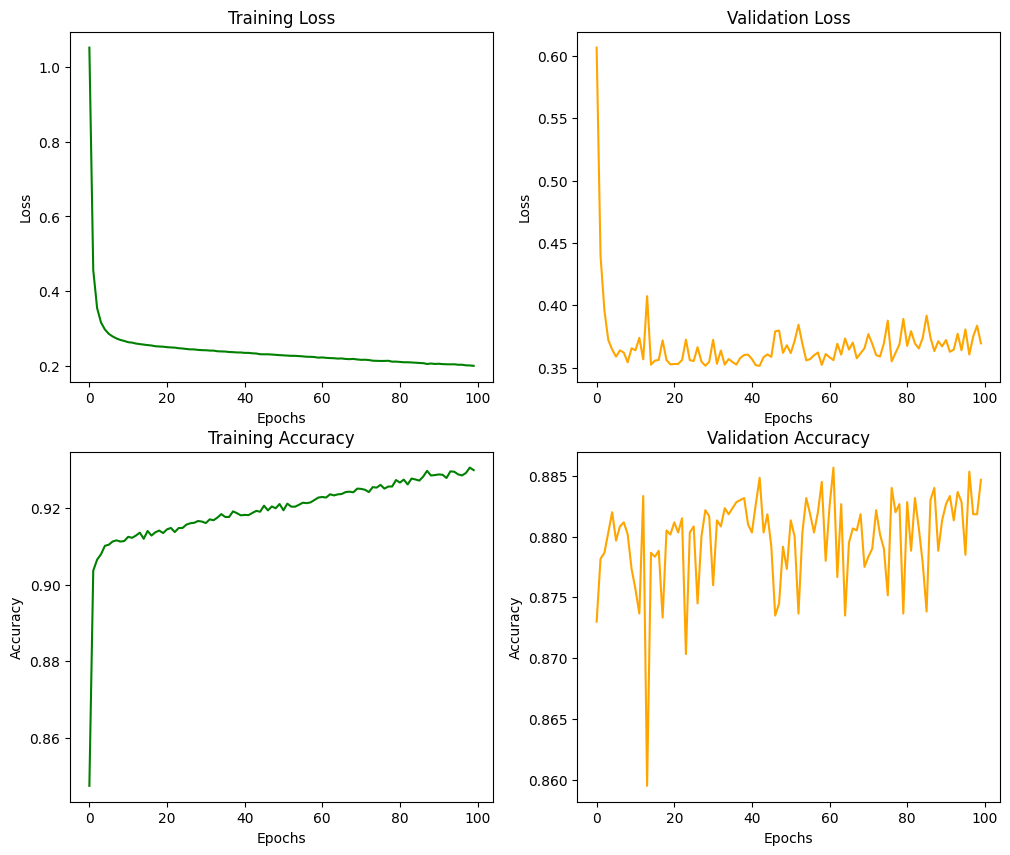

In [54]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [55]:
test()

Accuracy on test set: 0.8758


## Optimized 7: Gradient Normalization

In [59]:
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        
        return grad_input
    
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()
    
    def forward(self, x):
        return GradientNormalization.apply(x)

In [60]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        
        x = self.output(x)
        
        return x

input_dims = 784
hidden_dims = 128
output_dims = 10

lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [61]:
train_losses, val_losses, train_accs, val_accs = train()

Epoch 1/100, Train Loss: 1.6002, Train Acc: 0.2876, Val Loss: 1.3268, Val Acc: 0.3597
Epoch 2/100, Train Loss: 1.2970, Train Acc: 0.4111, Val Loss: 1.2138, Val Acc: 0.4492
Epoch 3/100, Train Loss: 1.1603, Train Acc: 0.4600, Val Loss: 1.0717, Val Acc: 0.5353
Epoch 4/100, Train Loss: 1.1016, Train Acc: 0.5005, Val Loss: 1.1422, Val Acc: 0.4922
Epoch 5/100, Train Loss: 1.0580, Train Acc: 0.5221, Val Loss: 1.0219, Val Acc: 0.5405
Epoch 6/100, Train Loss: 1.0357, Train Acc: 0.5265, Val Loss: 0.9895, Val Acc: 0.5452
Epoch 7/100, Train Loss: 1.0135, Train Acc: 0.5340, Val Loss: 0.9833, Val Acc: 0.5432
Epoch 8/100, Train Loss: 1.0148, Train Acc: 0.5248, Val Loss: 1.0024, Val Acc: 0.5437
Epoch 9/100, Train Loss: 1.0312, Train Acc: 0.5181, Val Loss: 1.2217, Val Acc: 0.4745
Epoch 10/100, Train Loss: 1.0081, Train Acc: 0.5202, Val Loss: 0.9730, Val Acc: 0.5482
Epoch 11/100, Train Loss: 1.0217, Train Acc: 0.5119, Val Loss: 1.0643, Val Acc: 0.5122
Epoch 12/100, Train Loss: 1.0965, Train Acc: 0.5040,

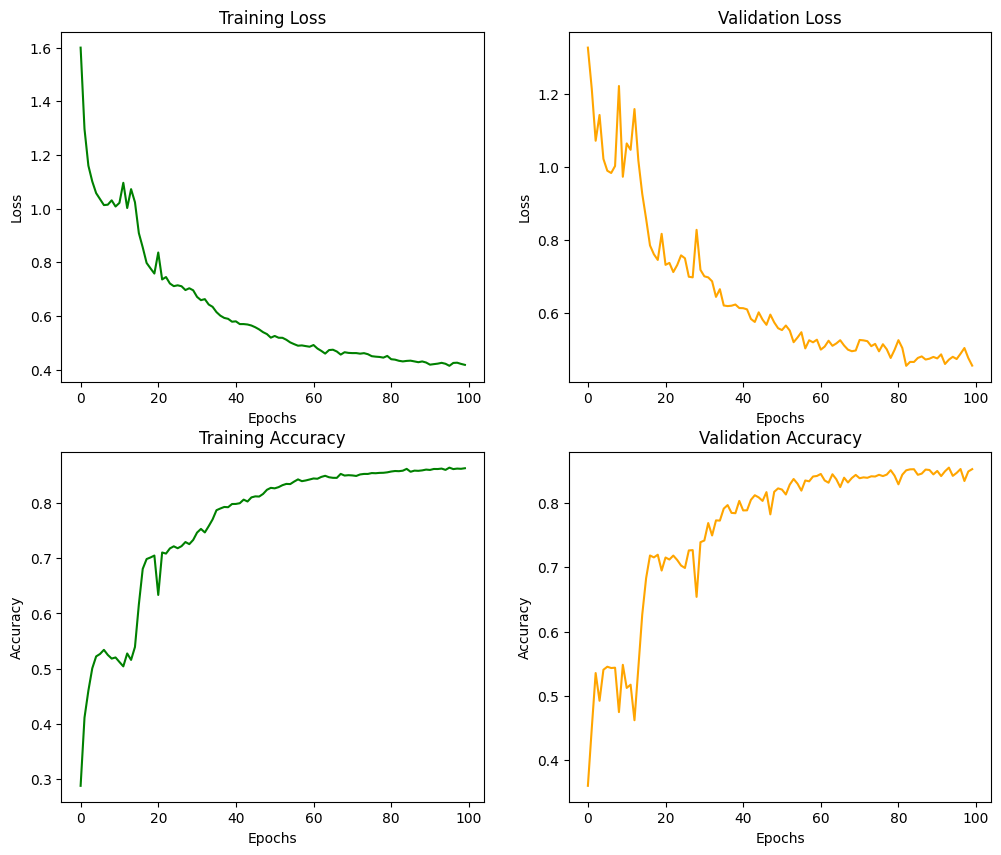

In [62]:
visualize(train_losses, val_losses, train_accs, val_accs)

In [63]:
test()

Accuracy on test set: 0.8447
